# Final Project - Artificial Intelligence
Convolutional Neural Network for the classification of Chest CT-Scan images

Team Members: 

Ricardo Azael Barragán Lona 1797270

Daniel Alberto Salas López 1896141

Miriam Coral Cera Ibarra 1902358

Ana Paola Valadez Estrada 1903151

Karla Daniela Rodríguez Martínez 1911849 


Import the needed libraries

In [10]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

Library to access the dataset located in Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Establishing variables to access the different image folders.
*   Train 70%
*   Validation 10%
*   Test 20%



In [12]:
train_set='/content/drive/MyDrive/Data/train'
val_set='/content/drive/MyDrive/Data/valid'
test_set='/content/drive/MyDrive/Data/test'

Sample generator according to the specified transformations.


In [13]:
train_datagen = image.ImageDataGenerator(
    #rescale = 1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
val_datagen= image.ImageDataGenerator(    
    #rescale = 1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    
    #rescale = 1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

Image preprocessing.

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


Model Architecture

EfficientNetB5 is the main neural network plus additional extra layers


In [15]:
base_model = tf.keras.applications.EfficientNetB5(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers[:-50]:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
model.add(GaussianNoise(0.25))
model.add(Dropout(rate= 0.45, seed= 123))
model.add(Dense(4, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 gaussian_noise_2 (GaussianN  (None, 7, 7, 2048)       0         
 oise)                                                           
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

Necessary data for the evaluation of the CNN.

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

Training and validation of the CNN.
* Epochs: 20
* Steps: 75


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch= 75,
    callbacks=checkpoint
    )

Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 1.7006 - accuracy: 0.5008 - auc: 0.7480 - precision: 0.5177 - recall: 0.4657
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to best_model.h5
75/75 [==============================] - 332s 4s/step - loss: 1.7006 - accuracy: 0.5008 - auc: 0.7480 - precision: 0.5177 - recall: 0.4657 - val_loss: 0.9597 - val_accuracy: 0.5556 - val_auc: 0.8379 - val_precision: 0.5714 - val_recall: 0.4444
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 1.0581 - accuracy: 0.6233 - auc: 0.8554 - precision: 0.6585 - recall: 0.5850
Epoch 2: val_accuracy improved from 0.55556 to 0.63889, saving model to best_model.h5
75/75 [==============================] - 15s 202ms/step - loss: 1.0581 - accuracy: 0.6233 - auc: 0.8554 - precision: 0.6585 - recall: 0.5850 - val_loss: 0.8659 - val_accuracy: 0.6389 - val_auc: 0.8870 - val_precision: 0.6765 - val_recall: 0.6389
Epoch 3/20
75/75 [==============================] -

Test evaluation.

In [18]:
model.evaluate(test_generator)

40/40 [==============================] - 170s 4s/step - loss: 1.1979 - accuracy: 0.7175 - auc: 0.8801 - precision: 0.7407 - recall: 0.6984


[1.1978754997253418,
 0.7174603343009949,
 0.8801108598709106,
 0.7407407164573669,
 0.6984127163887024]

Accurcy vs Validation Accuracy graph during the training of the CNN.

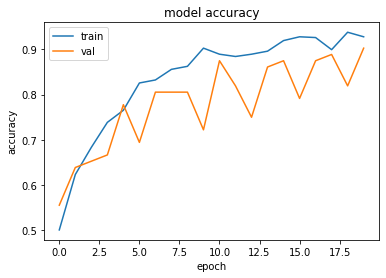

In [19]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("resnet_accuracy.png")
plt.show()

10 predictions after the training.

1/1 [==============================] - 4s 4s/step
[[4.4716965e-02 2.2331014e-02 9.3210089e-01 8.5118925e-04]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: ADENOCARCINOMA


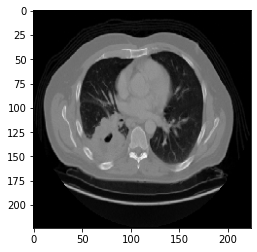

In [20]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/adenocarcinoma/000109 (4).png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: ADENOCARCINOMA") 

1/1 [==============================] - 0s 35ms/step
[[5.9847087e-01 1.3332947e-05 4.0125445e-01 2.6140551e-04]]
THE UPLOADED IMAGE IS SUSPECTED AS: Adenocarcinoma
THE REAL CATEGORY IS: ADENOCARCINOMA


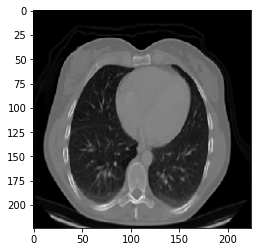

In [21]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/adenocarcinoma/000108 (3).png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: ADENOCARCINOMA") 

1/1 [==============================] - 0s 36ms/step
[[9.4946896e-05 5.0591040e-01 4.8835272e-01 5.6419093e-03]]
THE UPLOADED IMAGE IS SUSPECTED AS: large cell carcinoma
THE REAL CATEGORY IS: LARGE CELL CARCINOMA


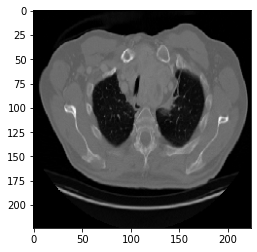

In [23]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/large.cell.carcinoma/000111 (2).png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: LARGE CELL CARCINOMA") 

1/1 [==============================] - 0s 39ms/step
[[0.0252932  0.02360808 0.8355799  0.11551885]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: LARGE CELL CARCINOMA


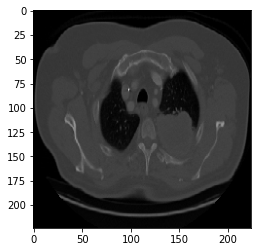

In [24]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/large.cell.carcinoma/000127 (2).png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 

print("THE REAL CATEGORY IS: LARGE CELL CARCINOMA") 

1/1 [==============================] - 0s 36ms/step
[[9.3689043e-05 7.7317101e-01 2.1984266e-01 6.8926732e-03]]
THE UPLOADED IMAGE IS SUSPECTED AS: large cell carcinoma
THE REAL CATEGORY IS: LARGE CEL CARCINOMA


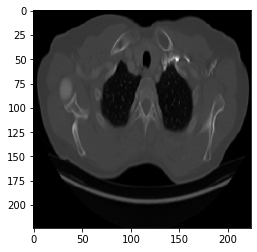

In [25]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/large.cell.carcinoma/000169.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 

print("THE REAL CATEGORY IS: LARGE CEL CARCINOMA") 

1/1 [==============================] - 0s 36ms/step
[[1.1256010e-12 2.4132308e-07 9.9999523e-01 4.5464635e-06]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: NORMAL (VOID OF CANCER)


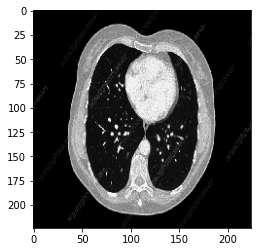

In [26]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/normal/6.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: NORMAL (VOID OF CANCER)") 

1/1 [==============================] - 0s 36ms/step
[[1.2093148e-11 8.2777540e-10 9.9999988e-01 1.0076433e-07]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: NORMAL (VOID OF CANCER)


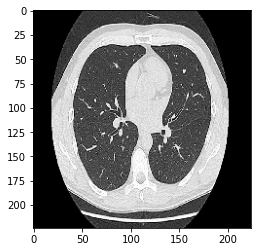

In [27]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/normal/7.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: NORMAL (VOID OF CANCER)") 

1/1 [==============================] - 0s 36ms/step
[[9.3066395e-05 9.4177760e-02 6.6485620e-01 2.4087292e-01]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA


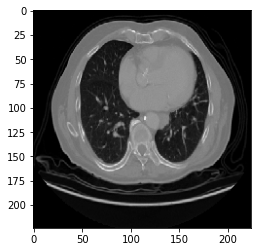

In [28]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/squamous.cell.carcinoma/000111.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA") 

1/1 [==============================] - 0s 38ms/step
[[4.2832873e-04 1.6482171e-01 3.9770257e-01 4.3704742e-01]]
THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA


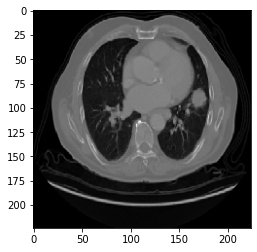

In [29]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

img =  image.load_img('/content/drive/MyDrive/Data/test/squamous.cell.carcinoma/000119.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA") 

1/1 [==============================] - 0s 37ms/step
[[9.3066395e-05 9.4177760e-02 6.6485620e-01 2.4087292e-01]]
THE UPLOADED IMAGE IS SUSPECTED AS: normal (void of cancer)
THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA


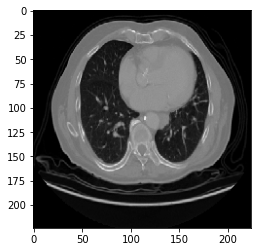

In [30]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
img =  image.load_img('/content/drive/MyDrive/Data/test/squamous.cell.carcinoma/000111.png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 
print("THE REAL CATEGORY IS: SQUAMOUS CELL CARCINOMA") 